Loading metadata...
Metadata loaded with 15000 entries
     - health: 2500 documents
     - sport: 2500 documents
     - technology: 2500 documents
     - economic: 2500 documents
     - politic: 2500 documents
     - environment: 2500 documents

Loading preprocessed texts...
   Progress: 1/15000 documents loaded (0.0%)
   Progress: 501/15000 documents loaded (3.3%)
   Progress: 1001/15000 documents loaded (6.7%)
   Progress: 1501/15000 documents loaded (10.0%)
   Progress: 2001/15000 documents loaded (13.3%)
   Progress: 2501/15000 documents loaded (16.7%)
   Progress: 3001/15000 documents loaded (20.0%)
   Progress: 3501/15000 documents loaded (23.3%)
   Progress: 4001/15000 documents loaded (26.7%)
   Progress: 4501/15000 documents loaded (30.0%)
   Progress: 5001/15000 documents loaded (33.3%)
   Progress: 5501/15000 documents loaded (36.7%)
   Progress: 6001/15000 documents loaded (40.0%)
   Progress: 6501/15000 documents loaded (43.3%)
   Progress: 7001/15000 documents loaded (46

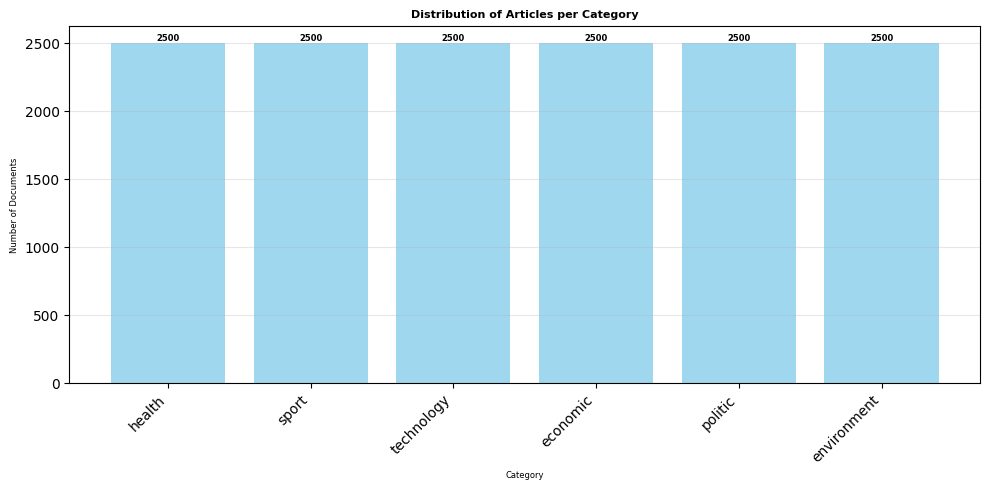

Split completed:
     - Training set: 12000 documents
     - Test set: 3000 documents
     - Unique categories in train: 6
     - Unique categories in test: 6
Summary:
   • Total documents loaded: 15000
   • Number of categories: 6
   • Training documents: 12000
   • Test documents: 3000


In [1]:
# MODULE 1: LIBRARY IMPORT AND PATH DEFINITION
# ============================================================================

# py Libraries
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report)
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix as cm_func

# Utility Libraries
import joblib
from tqdm import tqdm

# Define local project paths - all outputs stored in TF_IDF folder
PROCESSED_TEXTS_DIR = 'preprocessed_articles'
METADATA_PATH = 'metadata.csv'
MODELS_DIR = 'TF_IDF/models'
FEATURES_DIR = 'TF_IDF/features'

# Create directories if they don't exist
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(FEATURES_DIR, exist_ok=True)

def khmer_word_analyzer(text):
# This function extracts words containing Khmer characters and filters out non-Khmer characters.
    words = []
    for word in text.split():
        # Check if the word contains Khmer characters (Unicode range \u1780-\u17FF)
        if any(('\u1780' <= char <= '\u17FF') for char in word):
            # Remove any non-Khmer characters like punctuation
            khmer_word = ''.join(char for char in word if '\u1780' <= char <= '\u17FF' or char == '្')
            if len(khmer_word) >= 2:  # Only keep words with at least 2 characters
                words.append(khmer_word)
    return words

def load_texts_and_labels(metadata_path, processed_texts_dir):
    # This function reads a metadata CSV file to get document IDs and categories, then loads the corresponding text files from a specified directory.
    # Load metadata
    print("Loading metadata...")
    metadata = pd.read_csv(metadata_path)
    print(f"Metadata loaded with {len(metadata)} entries")
    
    category_counts = metadata['category'].value_counts()
    for category, count in category_counts.items():
        print(f"     - {category}: {count} documents")
    
    # Load texts and labels
    print(f"\nLoading preprocessed texts...")
    texts = []
    labels = []
    doc_ids = []
    
    total = len(metadata)
    for i, (_, row) in enumerate(metadata.iterrows()):
        # Print progress every 500 documents
        if i % 500 == 0 or i == total - 1:
            print(f"   Progress: {i+1}/{total} documents loaded ({(i+1)/total*100:.1f}%)")
            
        doc_id = row['docId']
        category = row['category']
        file_path = os.path.join(processed_texts_dir, f"{doc_id}.txt")
        
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
            texts.append(text)
            labels.append(category)
            doc_ids.append(doc_id)
        else:
            print(f"Warning: File not found for doc_id {doc_id}")
    
    print(f"Successfully loaded {len(texts)} documents")
    return texts, labels, doc_ids, metadata

def visualize_category_distribution(metadata):
    category_counts = metadata['category'].value_counts()
    
    plt.figure(figsize=(10, 5))
    bars = plt.bar(range(len(category_counts)), category_counts.values, color='skyblue', alpha=0.8)
    plt.title('Distribution of Articles per Category', fontsize=8, fontweight='bold')
    plt.xlabel('Category', fontsize=6)
    plt.ylabel('Number of Documents', fontsize=6)
    plt.xticks(range(len(category_counts)), category_counts.index, rotation=45, ha='right')
    
    # Add value labels on top of bars
    for bar, count in zip(bars, category_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5, 
                str(count), ha='center', va='bottom', fontsize=6, fontweight='bold')
    
    plt.tight_layout()
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    return category_counts

def create_train_test_split(texts, labels, test_size=0.2, random_state=42):
    
    X_train, X_test, y_train, y_test = train_test_split(
        texts, labels, test_size=test_size, random_state=random_state, stratify=labels
    )
    
    print(f"Split completed:")
    print(f"     - Training set: {len(X_train)} documents")
    print(f"     - Test set: {len(X_test)} documents")
    print(f"     - Unique categories in train: {len(set(y_train))}")
    print(f"     - Unique categories in test: {len(set(y_test))}")
    
    return X_train, X_test, y_train, y_test

# Load data
texts, labels, doc_ids, metadata = load_texts_and_labels(METADATA_PATH, PROCESSED_TEXTS_DIR)

# Visualize category distribution
print(f"\nGenerating category distribution visualization...")
category_counts = visualize_category_distribution(metadata)

# Create train-test split
X_train, X_test, y_train, y_test = create_train_test_split(texts, labels)

print(f"Summary:")
print(f"   • Total documents loaded: {len(texts)}")
print(f"   • Number of categories: {len(set(labels))}")
print(f"   • Training documents: {len(X_train)}")
print(f"   • Test documents: {len(X_test)}")
print("="*60)


Starting feature extraction...
Feature extraction completed!

Generating feature analysis...
Saving raw features...
Analyzing top 500 features per category...
   Categories found: ['economic', 'environment', 'health', 'politic', 'sport', 'technology']
   Calculating feature weights per category...
Creating feature extraction time visualization...


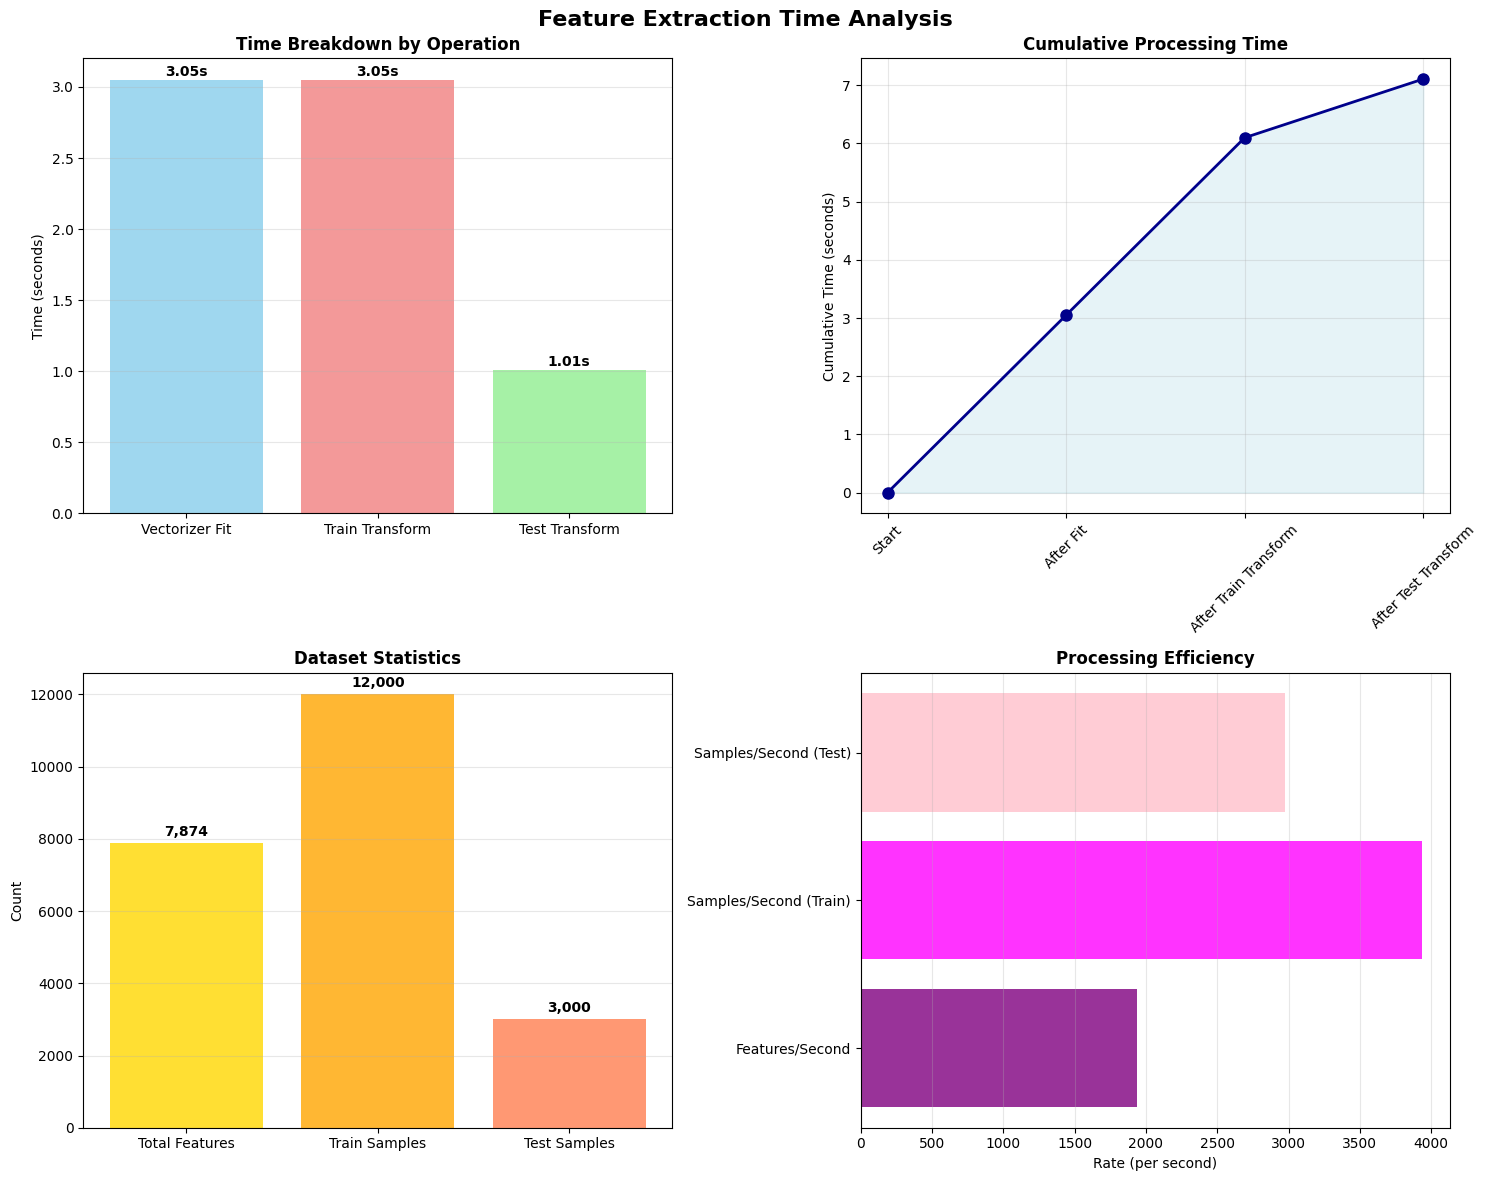


Summary Report:
Feature Statistics:
   • Total raw features extracted: 7,874
   • Top features per category: 500
   • Categories analyzed: 6
   • Common features across all categories: 64

Performance Metrics:
   • Total processing time: 4.06 seconds
   • Features per second: 1940
   • Training samples processed: 12,000
   • Test samples processed: 3,000

Ready for model training!
   • Training matrix: X_train_tfidf (12000, 7874)
   • Test matrix: X_test_tfidf (3000, 7874)
   • Vectorizer: tfidf_vectorizer
   • Labels: y_train, y_test


In [2]:
# MODULE 2.1: TF-IDF FEATURE EXTRACTION (Default Features)
# ============================================================================

def save_raw_features_to_file(vectorizer, output_dir):

    print("Saving raw features...")
    
    feature_names = vectorizer.get_feature_names_out()
    
    feature_file_path = os.path.join(output_dir, 'raw_features.txt')
    with open(feature_file_path, 'w', encoding='utf-8') as f:
        f.write("TF-IDF Raw Features\n")
        f.write("="*30 + "\n\n")
        f.write(f"Total Number of Features: {len(feature_names)}\n\n")
        f.write("Features List:\n")
        f.write("-"*20 + "\n")
        for i, feature in enumerate(feature_names):
            f.write(f"{i+1:>6}. {feature}\n")
    
    return len(feature_names)

def save_category_features(vectorizer, X_train_tfidf, y_train, output_dir, top_n=500):

    print(f"Analyzing top {top_n} features per category...")
    
    feature_names = vectorizer.get_feature_names_out()
    X_train_array = X_train_tfidf.toarray()
    
    categories = sorted(set(y_train))
    print(f"   Categories found: {categories}")
    
    # Calculate average TF-IDF scores per category
    category_feature_weights = defaultdict(lambda: np.zeros(len(feature_names)))
    category_doc_counts = Counter(y_train)
    
    print(f"   Calculating feature weights per category...")
    for i, category in enumerate(y_train):
        category_feature_weights[category] += X_train_array[i]
    
    for category in categories:
        category_feature_weights[category] /= category_doc_counts[category]
    
    # Save top features for each category
    category_features = defaultdict(list)
    top_features_path = os.path.join(output_dir, f'top_{top_n}_features_by_category.txt')
    
    with open(top_features_path, 'w', encoding='utf-8') as f:
        f.write(f"Top {top_n} Features by Category\n")
        f.write("="*40 + "\n\n")
        
        for category in categories:
            f.write(f"Category: {category}\n")
            f.write("-" * 30 + "\n")
            f.write(f"Documents in category: {category_doc_counts[category]}\n\n")
            
            weights = category_feature_weights[category]
            top_indices = weights.argsort()[::-1][:top_n]
            
            f.write(f"{'Rank':<6} {'Feature':<30} {'Weight':<12}\n")
            f.write("-" * 50 + "\n")
            
            feature_count = 0
            for rank, idx in enumerate(top_indices, 1):
                feature = feature_names[idx]
                weight = weights[idx]
                
                if weight > 0:
                    f.write(f"{rank:<6} {feature:<30} {weight:.8f}\n")
                    category_features[category].append(feature)
                    feature_count += 1
            
            f.write(f"\nActual features saved: {feature_count}\n")
            f.write("\n" + "="*40 + "\n\n")
    
    # Find common features across all categories
    common_features = set(category_features[categories[0]])
    for category in categories[1:]:
        common_features.intersection_update(set(category_features[category]))
    
    # Save common features
    common_features_path = os.path.join(output_dir, 'common_features_across_categories.txt')
    
    with open(common_features_path, 'w', encoding='utf-8') as f:
        f.write("Common Features Across All Categories\n")
        f.write("="*40 + "\n\n")
        f.write(f"Number of common features: {len(common_features)}\n\n")
        
        if len(common_features) > 0:
            f.write(f"{'Feature':<30} {'Avg Weight':<12} Category-specific Weights\n")
            f.write("-" * 80 + "\n")
            
            for feature in sorted(common_features):
                feature_idx = np.where(feature_names == feature)[0][0]
                avg_weight = np.mean([category_feature_weights[cat][feature_idx] for cat in categories])
                
                f.write(f"{feature:<30} {avg_weight:.8f}   ")
                
                cat_weights = []
                for cat in categories:
                    cat_weight = category_feature_weights[cat][feature_idx]
                    cat_weights.append(f"{cat}:{cat_weight:.6f}")
                
                f.write(", ".join(cat_weights) + "\n")
        else:
            f.write("No common features found across all categories.\n")
    
    return len(common_features)

def create_feature_extraction_time_visualization(extraction_times, output_dir):

    print("Creating feature extraction time visualization...")
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle("Feature Extraction Time Analysis", fontsize=16, fontweight='bold')
    
    # 1. Time breakdown bar chart
    times = [
        extraction_times['vectorizer_fit'],
        extraction_times['train_transform'],
        extraction_times['test_transform']
    ]
    labels = ['Vectorizer Fit', 'Train Transform', 'Test Transform']
    colors = ['skyblue', 'lightcoral', 'lightgreen']
    
    bars = ax1.bar(labels, times, color=colors, alpha=0.8)
    ax1.set_title('Time Breakdown by Operation', fontweight='bold')
    ax1.set_ylabel('Time (seconds)')
    ax1.grid(axis='y', alpha=0.3)
    
    for bar, time_val in zip(bars, times):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01, 
        f'{time_val:.2f}s', ha='center', va='bottom', fontweight='bold')
    
    # 2. Cumulative time
    cumulative_times = np.cumsum([0] + times)
    steps = ['Start', 'After Fit', 'After Train Transform', 'After Test Transform']
    
    ax2.plot(steps, cumulative_times, marker='o', linewidth=2, markersize=8, color='darkblue')
    ax2.fill_between(steps, cumulative_times, alpha=0.3, color='lightblue')
    ax2.set_title('Cumulative Processing Time', fontweight='bold')
    ax2.set_ylabel('Cumulative Time (seconds)')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Feature statistics
    feature_stats = [
        extraction_times['total_features'],
        extraction_times['train_samples'],
        extraction_times['test_samples']
    ]
    stat_labels = ['Total Features', 'Train Samples', 'Test Samples']
    
    ax3.bar(stat_labels, feature_stats, color=['gold', 'orange', 'coral'], alpha=0.8)
    ax3.set_title('Dataset Statistics', fontweight='bold')
    ax3.set_ylabel('Count')
    ax3.grid(axis='y', alpha=0.3)
    
    for i, (label, stat) in enumerate(zip(stat_labels, feature_stats)):
        ax3.text(i, stat + max(feature_stats)*0.01, f'{stat:,}', 
                ha='center', va='bottom', fontweight='bold')
    
    # 4. Processing efficiency
    efficiency_metrics = {
        'Features/Second': extraction_times['total_features'] / extraction_times['total_time'],
        'Samples/Second (Train)': extraction_times['train_samples'] / extraction_times['train_transform'],
        'Samples/Second (Test)': extraction_times['test_samples'] / extraction_times['test_transform']
    }
    
    metrics = list(efficiency_metrics.keys())
    values = list(efficiency_metrics.values())
    
    ax4.barh(metrics, values, color=['purple', 'magenta', 'pink'], alpha=0.8)
    ax4.set_title('Processing Efficiency', fontweight='bold')
    ax4.set_xlabel('Rate (per second)')
    ax4.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    
    # Save visualization
    viz_path = os.path.join(output_dir, 'feature_extraction_time_visualization.png')
    plt.savefig(viz_path, dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
# TF-IDF FEATURE EXTRACTION
# ============================================================================

# Initialize time tracking
extraction_times = {}
start_time = time.time()

# Create TF-IDF Vectorizer 
tfidf_vectorizer = TfidfVectorizer(
    analyzer=khmer_word_analyzer,
    max_features=None,      # Change to 3000 for limited features experiment
    min_df=5,              # Term must appear in at least 5 documents
    max_df=0.8,            # Term must appear in at most 80% of documents
    ngram_range=(1, 2)     # Include both unigrams and bigrams
)

print("\nStarting feature extraction...")

# Fit the vectorizer and transform training data
fit_start = time.time()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
extraction_times['vectorizer_fit'] = time.time() - fit_start

# Transform test data
transform_start = time.time()
X_test_tfidf = tfidf_vectorizer.transform(X_test)
extraction_times['test_transform'] = time.time() - transform_start

# Calculate additional timing metrics
extraction_times['train_transform'] = extraction_times['vectorizer_fit']
extraction_times['total_time'] = time.time() - start_time
extraction_times['total_features'] = X_train_tfidf.shape[1]
extraction_times['train_samples'] = X_train_tfidf.shape[0]
extraction_times['test_samples'] = X_test_tfidf.shape[0]

print("Feature extraction completed!")

print("\nGenerating feature analysis...")

# 1. Save raw features
total_features = save_raw_features_to_file(tfidf_vectorizer, FEATURES_DIR)

# 2. Save top 500 features per category and common features
common_count = save_category_features(tfidf_vectorizer, X_train_tfidf, y_train, FEATURES_DIR, top_n=500)

# 3. Create feature extraction time visualization
create_feature_extraction_time_visualization(extraction_times, FEATURES_DIR)

# 4. Save TF-IDF vectorizer
vectorizer_path = os.path.join(FEATURES_DIR, 'tfidf_vectorizer.joblib')
joblib.dump(tfidf_vectorizer, vectorizer_path)

# ============================================================================
# SUMMARY REPORT
# ============================================================================

print("\nSummary Report:")
print("="*50)
print("Feature Statistics:")
print(f"   • Total raw features extracted: {total_features:,}")
print(f"   • Top features per category: 500")
print(f"   • Categories analyzed: {len(set(y_train))}")
print(f"   • Common features across all categories: {common_count}")

print("\nPerformance Metrics:")
print(f"   • Total processing time: {extraction_times['total_time']:.2f} seconds")
print(f"   • Features per second: {total_features/extraction_times['total_time']:.0f}")
print(f"   • Training samples processed: {extraction_times['train_samples']:,}")
print(f"   • Test samples processed: {extraction_times['test_samples']:,}")

print("\nReady for model training!")
print(f"   • Training matrix: X_train_tfidf {X_train_tfidf.shape}")
print(f"   • Test matrix: X_test_tfidf {X_test_tfidf.shape}")
print(f"   • Vectorizer: tfidf_vectorizer")
print(f"   • Labels: y_train, y_test")

print("="*50)


Starting feature extraction with engineering...

Generating feature analysis...
Saving raw features...
Analyzing top 100 features per category...
   Calculating feature weights per category...
Creating feature extraction time visualization...


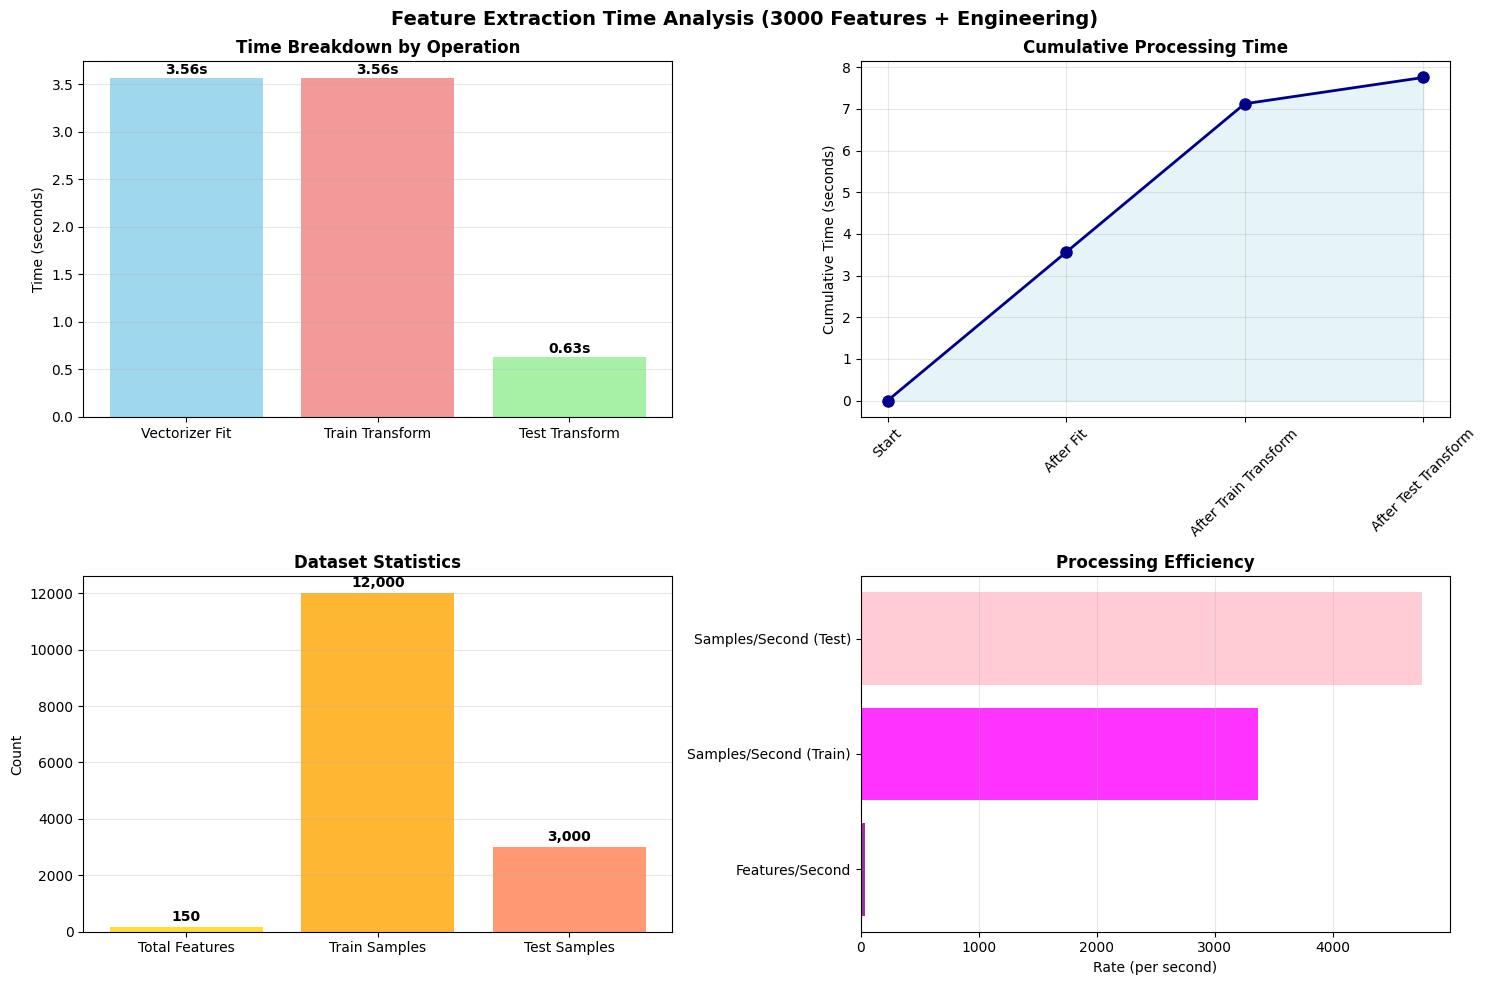


Summary Report:
Feature Engineering & Extraction:
   • Non-discriminative features removed: 236
   • Max features limit: 150
   • Total features extracted: 150
   • Categories analyzed: 6
   • Common features across all categories: 35

Performance Metrics:
   • Total processing time: 4.19 seconds
   • Features per second: 36
   • Training samples processed: 12,000
   • Test samples processed: 3,000

Ready for model training!
   • Training matrix: X_train_tfidf (12000, 150)
   • Test matrix: X_test_tfidf (3000, 150)
   • Vectorizer: tfidf_vectorizer
   • Labels: y_train, y_test


In [3]:
# MODULE 2.2: TF-IDF FEATURE EXTRACTION (LIMITED FEATURES = 200 + FEATURE ENGINEERING)

def get_features_to_remove():
    # DATE-RELATED FEATURES
    date_features = {
        "កក់ខែ", "កក្កដា", "កញ្ញា", "កុម្ភៈ", "ខែ", "ខែកក្កដា", "ខែកក្ត", "ខែកញ្ញា",
        "ខែកុម្ភ", "ខែកុម្ភះ", "ខែកុម្ភៈ", "ខែតុលា", "ខែត្រ", "ខែធ្នូ", "ខែម", "ខែមិគសិរ",
        "ខែមិថុនា", "ខែមីនា", "ខែមេសា", "ខែម្តង", "ខែម្តង", "ខែល", "ខែវិចិ្ឆកា", "ខែវិច្ឆកា",
        "ខែវិច្ឆិកា", "ខែសីហា", "ខែឧសភា", "ច័ន្ទ", "ឆ្នាំង", "ឆ្នាំងសាក", "ដើមឧសភា", "តុលា",
        "ថ្ងៃចន្ទ", "ថ្ងៃច័ន្ទ", "ថ្ងៃទី", "ថ្ងៃទីកក្កដា", "ថ្ងៃទីកញ្ញា", "ថ្ងៃពុធ", "ថ្ងៃព្រហស្បតិ៍",
        "ថ្ងៃព្រហស្បត្តិ៍", "ថ្ងៃសុក្រ", "ថ្ងៃសៅរ៍", "ថ្ងៃស្អែក", "ថ្ងៃអង្គារ", "ថ្ងៃអង្គារ៍",
        "ថ្ងៃអាទិត្យ", "ធ្នូ", "ពុធ", "ព្រហស្បតិ៍", "មិថុនា", "មីនា", "មេសា", "មេសាង",
        "ម៉ោង", "វិច្ឆិកា", "វិនាទី", "សប្តាហ៍", "សីហា", "សុក្រ", "សុក្រំ", "សៅរ៍", "អង្គារ",
        "អាទិត្យ", "អាទិត្យា", "ឧសភា"
    }
    
    # COUNTRY/LOCATION-RELATED FEATURES
    location_features = {
        "កម្ពុជា", "កូរ៉េ", "ក្រុង", "ខេត្ត", "ឃុំ", "ឃុំឃាំង", "ចិន", "ជប៉ុន", "ជាយក្រុង",
        "ថៃ", "ទីក្រុង", "នាទីក្រុង", "បារាំង", "ប៉ាគីស្ថាន", "ប្រេស៊ីល", "ភូមិ", "ភូមិគ្រឹះ",
        "ភូមិដ្ឋាន", "ភូមិឋាន", "ភូមិបាល", "ភូមិភាគ", "ភូមិសារ", "ភូមិសាស្ត្រ", "ភូមិសាស្រ្ត",
        "ភ្នំស្រុក", "មីយ៉ាន់ម៉ា", "មេភូមិ", "ម៉ាក្រុង", "ម៉ាឡេស៊ី", "យូហ្គោស្លាវី", "រាជធានី",
        "រុស្ស៊ី", "លាវ", "សាលាក្រុង", "សាលាខេត្ត", "សិង្ហបុរី", "ស្រុក", "អង់គ្លេស", "អាមេរិក",
        "អាមេរិកកាំង", "អាមេរិកាំង", "អាល្លឺម៉ង់", "អាស៊ី", "អាហ្វ្រិក", "អឺរ៉ុប", "អូស្ត្រាលី",
        "អេហ្ស៊ីប", "ឥណ្ឌា", "ឥណ្ឌូចិន", "ឥណ្ឌូណេស៊ី", "អេស្ប៉ាញ", "អាហ្សង់ទីន", "អារ៉ាប៊ី", 
        "ព័រទុយហ្គាល់", "ទីលាន", "សាអូឌីត", "ហ្វីលីពីន", "អ៊ីតាលី", "ហូឡង់", "ហ្វ្រាំង", 
        "អ៊ុយក្រែន", "អ៊ីស្រាអែល", "ប៉ារីស", "វិសាខា", "ស្វាយរៀង", "សៀមរាប", "ព្រះសីហនុ",
        "ស្ទឹងត្រែង", "មណ្ឌលគិរី", "រតនគិរី", "ព្រះវិហារ", "កោះកុង", "កំពង់ធំ",
        "បាត់ដំបង", "កំពង់ចាម", "កំពង់ស្ពឺ", "កណ្តាល", "កំពត", "ព្រៃវែង", "ត្បូងឃ្មុំ",
        "វ៉េស្ទឡាញន៍", "ណត្សឡាញន៍"
    }
    
    # NEUTRAL/CONTEXTUAL FEATURES
    neutral_features = {
        "កម្មវិធី", "កីឡាកាយ", "កីឡារិនី", "កំប្លោក", "ក្រុមព្រះខ័ន", "ក្រុមហា", "គីឡូ", 
        "គីឡូក្រាម", "គីឡូម៉ែត", "គីឡូម៉ែត្រ", "គីឡូវ៉ាត់", "គុណភាព", "ឃ្លោក", "ច្បាប់", 
        "ដុល្លា", "ដុល្លារ", "ទំហំ", "បច្ចេកទេស", "បច្ចេកវិទ្យាសាក", "ប្រធានាធិបតី", 
        "ពាក្យបច្ចេកទេស", "ពាក្យស្លោក", "ភពលោក", "មនុស្សលោក", "លោកគ្រូបង្វឹក",
        "លោកពូទីន", "លោកយាយ", "លោកស្រី", "លោក", "លោកស្រី", "អ្នកនាង",
        "ពាន់", "លាន", "ម៉ឺន", "ប៊ីលាន", "ពាន", "លេខ", "ចំនួន", "សរុប", "ប្រមាណ", "គយ",
        "មនុស្ស", "វ័យ", "អាយុ", "ផងដែរ", "ផង", "ទៀន", "ទើប", "ម្តង", "ជាដើម", "ជាពិសេស", 
        "ពិសេស", "ពិបាក", "ប្រសើរ", "ធំ", "តូច", "ពេក", "យូរ", "លឿន", "ខ្លី", "វែង", "ពេល", 
        "ពេលខ្លះ", "ពេលនេះ", "ពេលនោះ", "រយៈពេល", "អំឡុង", "អំឡុងពេល", "ជារៀងរាល់",
        "ផ្សេង", "នានា", "ដទៃ", "ផ្សេងៗ", "ទូទៅ", "ធម្មតា", "ពិតជា", "ពិត",
        "លក្ខណៈ", "សម្បត្តិ", "សមត្ថភាព", "លទ្ធភាព", "សក្តានុពល", "អត្ថបទ", "រ៉ាឌី", "សុន", 
        "ខ្មែរ", "ជុំវិញ", "កុំ", "រវាង", "ក្រៅ", "ខណៈ"
    }
    
    # Combine all features to remove
    features_to_remove = date_features.union(location_features).union(neutral_features)
    
    return features_to_remove

def khmer_word_analyzer_with_filtering(text):

    # Get features to remove
    features_to_remove = get_features_to_remove()
    
    words = []
    for word in text.split():
        # Check if the word contains Khmer characters (Unicode range \u1780-\u17FF)
        if any(('\u1780' <= char <= '\u17FF') for char in word):
            # Remove any non-Khmer characters like punctuation
            khmer_word = ''.join(char for char in word if '\u1780' <= char <= '\u17FF' or char == '្')
            
            # Apply feature filtering
            if len(khmer_word) >= 2 and khmer_word not in features_to_remove:
                words.append(khmer_word)
    
    return words

# ============================================================================
# FEATURE EXTRACTION FUNCTIONS
# ============================================================================

def save_raw_features_to_file(vectorizer, output_dir):

    print("Saving raw features...")
    
    feature_names = vectorizer.get_feature_names_out()
    
    feature_file_path = os.path.join(output_dir, 'raw_features_filtered.txt')
    with open(feature_file_path, 'w', encoding='utf-8') as f:
        f.write("TF-IDF Raw Features (After Feature Engineering)\n")
        f.write("="*50 + "\n\n")
        f.write(f"Max Features Limit: 3000\n")
        f.write(f"Total Number of Features: {len(feature_names)}\n")
        f.write(f"Feature Engineering Applied: Non-discriminative features removed\n\n")
        f.write("Features List:\n")
        f.write("-"*20 + "\n")
        for i, feature in enumerate(feature_names):
            f.write(f"{i+1:>6}. {feature}\n")
    
    return len(feature_names)

def save_category_features(vectorizer, X_train_tfidf, y_train, output_dir, top_n=500):
    """
    Analyze and save top features for each category and common features.
    
    Args:
        vectorizer: The fitted TF-IDF vectorizer
        X_train_tfidf: TF-IDF matrix of training data
        y_train: Training labels
        output_dir: Directory to save the feature analysis
        top_n: Number of top features to save per category
    """
    print(f"Analyzing top {top_n} features per category...")
    
    feature_names = vectorizer.get_feature_names_out()
    X_train_array = X_train_tfidf.toarray()
    
    categories = sorted(set(y_train))
    
    # Calculate average TF-IDF scores per category
    category_feature_weights = defaultdict(lambda: np.zeros(len(feature_names)))
    category_doc_counts = Counter(y_train)
    
    print(f"   Calculating feature weights per category...")
    for i, category in enumerate(y_train):
        category_feature_weights[category] += X_train_array[i]
    
    for category in categories:
        category_feature_weights[category] /= category_doc_counts[category]
    
    # Save top features for each category
    category_features = defaultdict(list)
    top_features_path = os.path.join(output_dir, f'top_{top_n}_features_by_category_filtered.txt')
    
    with open(top_features_path, 'w', encoding='utf-8') as f:
        f.write(f"Top {top_n} Features by Category (After Feature Engineering)\n")
        f.write("="*60 + "\n\n")
        f.write(f"Feature Engineering Applied: Non-discriminative features removed\n")
        f.write(f"Max Features Limit: 3000\n\n")
        
        for category in categories:
            f.write(f"Category: {category}\n")
            f.write("-" * 30 + "\n")
            f.write(f"Documents in category: {category_doc_counts[category]}\n\n")
            
            weights = category_feature_weights[category]
            top_indices = weights.argsort()[::-1][:top_n]
            
            f.write(f"{'Rank':<6} {'Feature':<30} {'Weight':<12}\n")
            f.write("-" * 50 + "\n")
            
            feature_count = 0
            for rank, idx in enumerate(top_indices, 1):
                feature = feature_names[idx]
                weight = weights[idx]
                
                if weight > 0:
                    f.write(f"{rank:<6} {feature:<30} {weight:.8f}\n")
                    category_features[category].append(feature)
                    feature_count += 1
            
            f.write(f"\nActual features saved: {feature_count}\n")
            f.write("\n" + "="*60 + "\n\n")
    
    # Find common features across all categories
    
    common_features = set(category_features[categories[0]])
    for category in categories[1:]:
        common_features.intersection_update(set(category_features[category]))
    
    # Save common features
    common_features_path = os.path.join(output_dir, 'common_features_across_categories_filtered.txt')
    
    with open(common_features_path, 'w', encoding='utf-8') as f:
        f.write("Common Features Across All Categories (After Feature Engineering)\n")
        f.write("="*60 + "\n\n")
        f.write(f"Feature Engineering Applied: Non-discriminative features removed\n")
        f.write(f"Number of common features: {len(common_features)}\n\n")
        
        if len(common_features) > 0:
            f.write(f"{'Feature':<30} {'Avg Weight':<12} Category-specific Weights\n")
            f.write("-" * 80 + "\n")
            
            for feature in sorted(common_features):
                feature_idx = np.where(feature_names == feature)[0][0]
                avg_weight = np.mean([category_feature_weights[cat][feature_idx] for cat in categories])
                
                f.write(f"{feature:<30} {avg_weight:.8f}   ")
                
                cat_weights = []
                for cat in categories:
                    cat_weight = category_feature_weights[cat][feature_idx]
                    cat_weights.append(f"{cat}:{cat_weight:.6f}")
                
                f.write(", ".join(cat_weights) + "\n")
        else:
            f.write("No common features found across all categories.\n")
    
    return len(common_features)

def create_feature_extraction_time_visualization(extraction_times, output_dir):

    print("Creating feature extraction time visualization...")
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle("Feature Extraction Time Analysis (3000 Features + Engineering)", fontsize=14, fontweight='bold')
    
    # 1. Time breakdown bar chart
    times = [
        extraction_times['vectorizer_fit'],
        extraction_times['train_transform'],
        extraction_times['test_transform']
    ]
    labels = ['Vectorizer Fit', 'Train Transform', 'Test Transform']
    colors = ['skyblue', 'lightcoral', 'lightgreen']
    
    bars = ax1.bar(labels, times, color=colors, alpha=0.8)
    ax1.set_title('Time Breakdown by Operation', fontweight='bold')
    ax1.set_ylabel('Time (seconds)')
    ax1.grid(axis='y', alpha=0.3)
    
    for bar, time_val in zip(bars, times):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01, 
                f'{time_val:.2f}s', ha='center', va='bottom', fontweight='bold')
    
    # 2. Cumulative time
    cumulative_times = np.cumsum([0] + times)
    steps = ['Start', 'After Fit', 'After Train Transform', 'After Test Transform']
    
    ax2.plot(steps, cumulative_times, marker='o', linewidth=2, markersize=8, color='darkblue')
    ax2.fill_between(steps, cumulative_times, alpha=0.3, color='lightblue')
    ax2.set_title('Cumulative Processing Time', fontweight='bold')
    ax2.set_ylabel('Cumulative Time (seconds)')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Feature statistics
    feature_stats = [
        extraction_times['total_features'],
        extraction_times['train_samples'],
        extraction_times['test_samples']
    ]
    stat_labels = ['Total Features', 'Train Samples', 'Test Samples']
    
    ax3.bar(stat_labels, feature_stats, color=['gold', 'orange', 'coral'], alpha=0.8)
    ax3.set_title('Dataset Statistics', fontweight='bold')
    ax3.set_ylabel('Count')
    ax3.grid(axis='y', alpha=0.3)
    
    for i, (label, stat) in enumerate(zip(stat_labels, feature_stats)):
        ax3.text(i, stat + max(feature_stats)*0.01, f'{stat:,}', 
                ha='center', va='bottom', fontweight='bold')
    
    # 4. Processing efficiency
    efficiency_metrics = {
        'Features/Second': extraction_times['total_features'] / extraction_times['total_time'],
        'Samples/Second (Train)': extraction_times['train_samples'] / extraction_times['train_transform'],
        'Samples/Second (Test)': extraction_times['test_samples'] / extraction_times['test_transform']
    }
    
    metrics = list(efficiency_metrics.keys())
    values = list(efficiency_metrics.values())
    
    ax4.barh(metrics, values, color=['purple', 'magenta', 'pink'], alpha=0.8)
    ax4.set_title('Processing Efficiency', fontweight='bold')
    ax4.set_xlabel('Rate (per second)')
    ax4.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    
    # Save visualization
    viz_path = os.path.join(output_dir, 'feature_extraction_time_visualization_filtered.png')
    plt.savefig(viz_path, dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
# TF-IDF FEATURE EXTRACTION WITH FEATURE ENGINEERING
# ============================================================================

# Initialize time tracking
extraction_times = {}
start_time = time.time()

# Initialize feature filtering (this will print filtering statistics)
features_to_remove = get_features_to_remove()

# Create TF-IDF Vectorizer with enhanced feature filtering
tfidf_vectorizer = TfidfVectorizer(
    analyzer=khmer_word_analyzer_with_filtering,  # Enhanced analyzer with filtering
    max_features= 150,          # Limited to 150 features
    min_df=5,                  # Term must appear in at least 5 documents
    max_df=0.8,                # Term must appear in at most 80% of documents
    ngram_range=(1, 2)         # Include both unigrams and bigrams
)

print("\nStarting feature extraction with engineering...")

# Fit the vectorizer and transform training data
fit_start = time.time()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
extraction_times['vectorizer_fit'] = time.time() - fit_start

# Transform test data
transform_start = time.time()
X_test_tfidf = tfidf_vectorizer.transform(X_test)
extraction_times['test_transform'] = time.time() - transform_start

# Calculate additional timing metrics
extraction_times['train_transform'] = extraction_times['vectorizer_fit']
extraction_times['total_time'] = time.time() - start_time
extraction_times['total_features'] = X_train_tfidf.shape[1]
extraction_times['train_samples'] = X_train_tfidf.shape[0]
extraction_times['test_samples'] = X_test_tfidf.shape[0]

# ============================================================================
# GENERATE OUTPUTS
# ============================================================================

print("\nGenerating feature analysis...")

# 1. Save raw features (filtered)
total_features = save_raw_features_to_file(tfidf_vectorizer, FEATURES_DIR)

# 2. Save top 100 features per category and common features (filtered)
common_count = save_category_features(tfidf_vectorizer, X_train_tfidf, y_train, FEATURES_DIR, top_n=100)

# 3. Create feature extraction time visualization
create_feature_extraction_time_visualization(extraction_times, FEATURES_DIR)

# 4. Save TF-IDF vectorizer
vectorizer_path = os.path.join(FEATURES_DIR, 'tfidf_vectorizer_filtered.joblib')
joblib.dump(tfidf_vectorizer, vectorizer_path)

# ============================================================================
# SUMMARY REPORT
# ============================================================================

print("\nSummary Report:")
print("="*60)
print("Feature Engineering & Extraction:")
print(f"   • Non-discriminative features removed: {len(features_to_remove)}")
print(f"   • Max features limit: {tfidf_vectorizer.max_features}")
print(f"   • Total features extracted: {total_features:,}")
print(f"   • Categories analyzed: {len(set(y_train))}")
print(f"   • Common features across all categories: {common_count}")

print("\nPerformance Metrics:")
print(f"   • Total processing time: {extraction_times['total_time']:.2f} seconds")
print(f"   • Features per second: {total_features/extraction_times['total_time']:.0f}")
print(f"   • Training samples processed: {extraction_times['train_samples']:,}")
print(f"   • Test samples processed: {extraction_times['test_samples']:,}")


print("\nReady for model training!")
print(f"   • Training matrix: X_train_tfidf {X_train_tfidf.shape}")
print(f"   • Test matrix: X_test_tfidf {X_test_tfidf.shape}")
print(f"   • Vectorizer: tfidf_vectorizer")
print(f"   • Labels: y_train, y_test")

print("="*60)

Vectorizer feature count: 150

Initializing SVM training pipeline...

Starting SVM training...

Performing 10-Fold Cross-Validation...

Evaluating on test set...
Creating learning curve visualization...


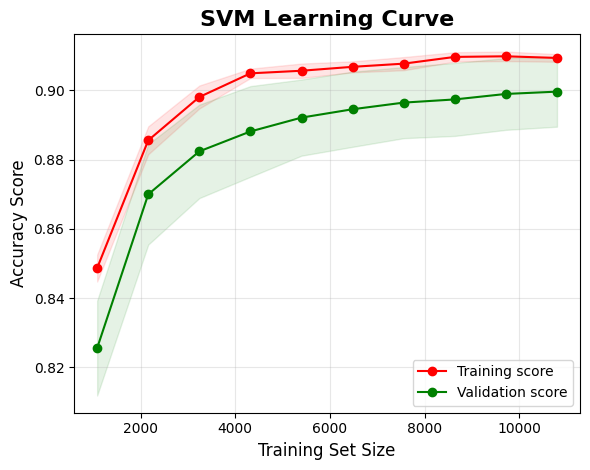

   Learning curve saved to: TF_IDF/models/svm_learning_curve.png
Creating confusion matrix visualization...


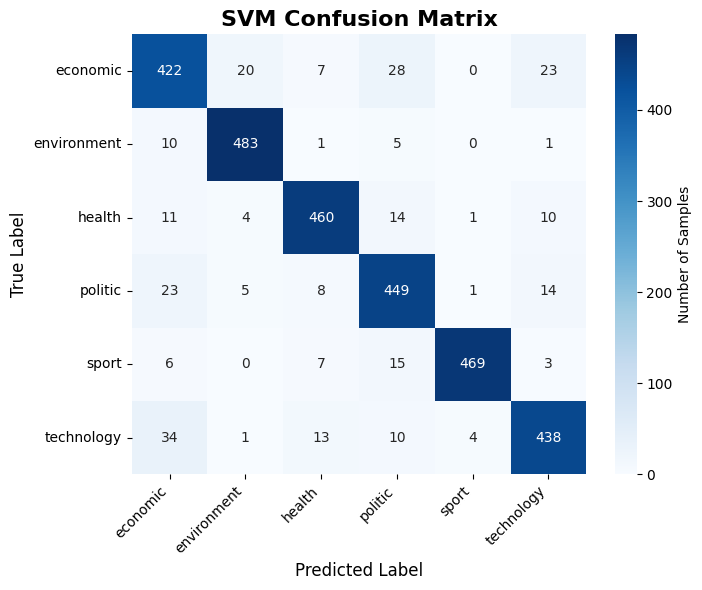

   Confusion matrix saved to: TF_IDF/models/svm_confusion_matrix.png
Performing error analysis...
   Found 279 misclassified instances out of 3000 test samples
   Overall error rate: 9.30%
   Error analysis saved to: TF_IDF/models/svm_error_analysis.txt

   Categories with Highest Error Rates:
     economic: 15.60% error rate (422/500 correctly classified)
     technology: 12.40% error rate (438/500 correctly classified)
     politic: 10.20% error rate (449/500 correctly classified)
     health: 8.00% error rate (460/500 correctly classified)
     sport: 6.20% error rate (469/500 correctly classified)
Generating classification report...

SVM model saved to: TF_IDF/models/svm_model.joblib
Model information saved to: TF_IDF/models/svm_model_info.txt

SVM Training Summary Report:

Vectorizer Information:
   • File: tfidf_vectorizer_filtered.joblib

Training Results:
   • Training time: 49.62 seconds
   • Training accuracy: 0.9104
   • Cross-validation accuracy: 0.8997 (±0.0101)

Test Perf

In [4]:
# MODULE 3: SVM TRAINING
# ============================================================================

# Choose which vectorizer to use:
# "tfidf_vectorizer.joblib" for default TF-IDF (unlimited features)
# "tfidf_vectorizer_filtered.joblib" for feature engineered TF-IDF (3000 features)
VECTORIZER_FILENAME = "tfidf_vectorizer_filtered.joblib"
# VECTORIZER_FILENAME = "tfidf_vectorizer.joblib"

# Construct full path to vectorizer
vectorizer_path = os.path.join(FEATURES_DIR, VECTORIZER_FILENAME)

# Verify the file exists before proceeding
if not os.path.exists(vectorizer_path):
    print(f"\nERROR: Vectorizer file not found!")
    print(f"Expected path: {vectorizer_path}")
    
    # Show what files actually exist in FEATURES_DIR
    if os.path.exists(FEATURES_DIR):
        print(f"\nFiles currently in {FEATURES_DIR}:")
        for file in os.listdir(FEATURES_DIR):
            if file.endswith('.joblib'):
                print(f"   • {file}")
    else:
        print(f"\nFEATURES_DIR does not exist: {FEATURES_DIR}")
    raise FileNotFoundError(f"Vectorizer file not found: {vectorizer_path}")

# Load the specified vectorizer
try:
    tfidf_vectorizer = joblib.load(vectorizer_path)
    print(f"Vectorizer feature count: {len(tfidf_vectorizer.get_feature_names_out()):,}")
except Exception as e:
    print(f"ERROR loading vectorizer: {e}")
    raise

# ============================================================================
# SVM TRAINING FUNCTIONS
# ============================================================================

def train_svm_model(X_train, y_train, X_test, y_test):

    # Initialize SVM model with specified parameters
    # svm_model = SVC(
    #     # C=1,
    #     # kernel='rbf',
    #     # gamma=0.01,
    #     # decision_function_shape='ovr',
    #     # random_state=42
    #     C=0.1,  # Reduced from 1.0 to reduce overfitting
    #     kernel='rbf',
    #     gamma='scale',  # Changed from fixed 0.01 to adaptive scaling
    #     class_weight='balanced',
    #     decision_function_shape='ovr',
    #     probability=True,
    #     random_state=42
    # )

    svm_model = SVC(
        C=0.1,
        kernel='rbf',
        gamma='scale',
        class_weight='balanced',
        decision_function_shape='ovr',
        probability=True,
        random_state=42
    )
    
    
    # Initialize results dictionary
    results = {
        'model': svm_model,
        'model_name': 'SVM'
    }
    
    # Track training time
    print("\nStarting SVM training...")
    start_time = time.time()
    
    # Train the model
    svm_model.fit(X_train, y_train)
    training_time = time.time() - start_time
    results['training_time'] = training_time
    
    # Calculate training accuracy
    train_pred = svm_model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_pred)
    results['train_accuracy'] = train_accuracy
    
    return results

def perform_cross_validation(model, X_train, y_train, cv_folds=10):

    print(f"\nPerforming {cv_folds}-Fold Cross-Validation...")
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='accuracy')
    
    cv_results = {
        'cv_scores': cv_scores,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    return cv_results

def evaluate_model_on_test(model, X_test, y_test):

    print("\nEvaluating on test set...")
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    test_results = {
        'y_pred': y_pred,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }
    
    return test_results

def create_confusion_matrix_visualization(y_test, y_pred, categories, output_dir):

    print("Creating confusion matrix visualization...")
    
    # Import to avoid any naming conflicts
    import sklearn.metrics
    
    # Create confusion matrix using full module path
    cm = sklearn.metrics.confusion_matrix(y_test, y_pred, labels=categories)
    
    # Create visualization
    plt.figure(figsize=(7.2, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=categories, yticklabels=categories,
                cbar_kws={'label': 'Number of Samples'})
    
    plt.title('SVM Confusion Matrix', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save visualization
    filename = f'svm_confusion_matrix.png'
    cm_path = os.path.join(output_dir, filename)
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"   Confusion matrix saved to: {cm_path}")
    
    return cm

def create_learning_curve_visualization(model, X_train, y_train, output_dir, cv_folds=10):

    print("Creating learning curve visualization...")
    
    try:
        # Generate learning curve data
        train_sizes = np.linspace(0.1, 1.0, 10)
        train_sizes_abs, train_scores, val_scores = learning_curve(
            model, X_train, y_train, 
            train_sizes=train_sizes, 
            cv=cv_folds, 
            scoring='accuracy',
            n_jobs=-1
        )
        
        # Calculate mean and standard deviation
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)
        
        # Create visualization
        plt.figure(figsize=(6, 4.8))
        plt.plot(train_sizes_abs, train_mean, 'o-', color='r', label='Training score')
        plt.plot(train_sizes_abs, val_mean, 'o-', color='g', label='Validation score')
        plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
        plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')
        
        plt.title('SVM Learning Curve', fontsize=16, fontweight='bold')
        plt.xlabel('Training Set Size', fontsize=12)
        plt.ylabel('Accuracy Score', fontsize=12)
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # Save visualization
        filename = f'svm_learning_curve.png'
        lc_path = os.path.join(output_dir, filename)
        plt.savefig(lc_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"   Learning curve saved to: {lc_path}")
        
        return {
            'train_sizes': train_sizes_abs,
            'train_scores': train_scores,
            'val_scores': val_scores
        }
    
    except Exception as e:
        print(f"   Warning: Could not generate learning curve. Error: {e}")
        return None

def perform_error_analysis(y_test, y_pred, categories, output_dir):

    print("Performing error analysis...")
    
    # Identify misclassified instances
    misclassified_mask = np.array(y_test) != np.array(y_pred)
    misclassified_indices = np.where(misclassified_mask)[0]
    
    if len(misclassified_indices) == 0:
        print("   No misclassified instances found.")
        return
    
    print(f"   Found {len(misclassified_indices)} misclassified instances out of {len(y_test)} test samples")
    print(f"   Overall error rate: {len(misclassified_indices)/len(y_test)*100:.2f}%")
    
    # Group errors by true category
    errors_by_category = {}
    for idx in misclassified_indices:
        true_category = y_test[idx]
        pred_category = y_pred[idx]
        
        if true_category not in errors_by_category:
            errors_by_category[true_category] = []
        
        errors_by_category[true_category].append(pred_category)
    
    # Calculate error rate by category
    error_rates = {}
    for category in categories:
        category_count = sum(1 for y in y_test if y == category)
        if category_count == 0:
            continue
        
        misclassified_count = len(errors_by_category.get(category, []))
        error_rate = misclassified_count / category_count
        error_rates[category] = error_rate
    
    # Save error analysis to file
    filename = f'svm_error_analysis.txt'
    error_analysis_path = os.path.join(output_dir, filename)
    
    with open(error_analysis_path, 'w', encoding='utf-8') as f:
        f.write("SVM Error Analysis\n")
        f.write("="*40 + "\n\n")
        f.write(f"Total test samples: {len(y_test)}\n")
        f.write(f"Misclassified samples: {len(misclassified_indices)}\n")
        f.write(f"Overall error rate: {len(misclassified_indices)/len(y_test)*100:.2f}%\n\n")
        
        f.write("Error Rates by Category:\n")
        f.write("-"*30 + "\n")
        sorted_categories = sorted(error_rates.items(), key=lambda x: x[1], reverse=True)
        for category, error_rate in sorted_categories:
            correct_count = sum(1 for y in y_test if y == category) - len(errors_by_category.get(category, []))
            total_count = sum(1 for y in y_test if y == category)
            f.write(f"{category}: {error_rate:.2%} error rate ({correct_count}/{total_count} correctly classified)\n")
        
        # Common confusion pairs
        confusion_pairs = {}
        for true_category, errors in errors_by_category.items():
            for pred_category in errors:
                pair = (true_category, pred_category)
                confusion_pairs[pair] = confusion_pairs.get(pair, 0) + 1
        
        f.write(f"\nMost Common Confusion Pairs (True -> Predicted):\n")
        f.write("-"*50 + "\n")
        sorted_pairs = sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)
        for (true_cat, pred_cat), count in sorted_pairs[:10]:
            f.write(f"{true_cat} -> {pred_cat}: {count} instances\n")
    
    print(f"   Error analysis saved to: {error_analysis_path}")
    
    # Display top categories with highest error rates
    print("\n   Categories with Highest Error Rates:")
    sorted_categories = sorted(error_rates.items(), key=lambda x: x[1], reverse=True)
    for category, error_rate in sorted_categories[:5]:
        correct_count = sum(1 for y in y_test if y == category) - len(errors_by_category.get(category, []))
        total_count = sum(1 for y in y_test if y == category)
        print(f"     {category}: {error_rate:.2%} error rate ({correct_count}/{total_count} correctly classified)")

def save_classification_report(y_test, y_pred, categories, output_dir):

    print("Generating classification report...")
    
    # Generate classification report
    class_report = classification_report(y_test, y_pred, target_names=categories, digits=4)
    
    # Save to file
    filename = f'svm_classification_report.txt'
    report_path = os.path.join(output_dir, filename)
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("SVM Classification Report\n")
        f.write("="*40 + "\n\n")
        f.write(class_report)
        f.write("\n\n")
        
        # Add per-class metrics
        f.write("Per-Class Metrics Summary:\n")
        f.write("-"*30 + "\n")
        
        for category in categories:
            category_mask = np.array(y_test) == category
            if np.sum(category_mask) > 0:
                category_pred = np.array(y_pred)[category_mask]
                category_true = np.array(y_test)[category_mask]
                
                precision = precision_score(category_true, category_pred, labels=[category], average='macro')
                recall = recall_score(category_true, category_pred, labels=[category], average='macro')
                f1 = f1_score(category_true, category_pred, labels=[category], average='macro')
                
                f.write(f"{category}:\n")
                f.write(f"  Precision: {precision:.4f}\n")
                f.write(f"  Recall: {recall:.4f}\n")
                f.write(f"  F1-Score: {f1:.4f}\n")
                f.write(f"  Support: {np.sum(category_mask)}\n\n")

# ============================================================================
# SVM MODEL TRAINING AND EVALUATION
# ============================================================================

print(f"\nInitializing SVM training pipeline...")

# Get unique categories for analysis
categories = sorted(set(y_train))

# Train SVM model
svm_results = train_svm_model(X_train_tfidf, y_train, X_test_tfidf, y_test)

# Perform cross-validation
cv_results = perform_cross_validation(svm_results['model'], X_train_tfidf, y_train, cv_folds=10)
svm_results.update(cv_results)

# Evaluate on test set
test_results = evaluate_model_on_test(svm_results['model'], X_test_tfidf, y_test)
svm_results.update(test_results)

# Create learning curve visualization
learning_curve_data = create_learning_curve_visualization(
    svm_results['model'], X_train_tfidf, y_train, MODELS_DIR, cv_folds=10
)

# Create confusion matrix visualization
cm_result = create_confusion_matrix_visualization(
    y_test, svm_results['y_pred'], categories, MODELS_DIR
)

# Perform error analysis
perform_error_analysis(y_test, svm_results['y_pred'], categories, MODELS_DIR)

# Generate classification report
save_classification_report(y_test, svm_results['y_pred'], categories, MODELS_DIR)

# Save the trained model
model_filename = f'svm_model.joblib'
model_path = os.path.join(MODELS_DIR, model_filename)
joblib.dump(svm_results['model'], model_path)

print(f"\nSVM model saved to: {model_path}")

# Create a model info file for clarity  
info_filename = f'svm_model_info.txt'
info_path = os.path.join(MODELS_DIR, info_filename)

with open(info_path, 'w', encoding='utf-8') as f:
    f.write(f"SVM Model Information\n")
    f.write("="*60 + "\n\n")
    f.write("Model Files:\n")
    f.write(f"   • Model: {model_filename}\n")
    f.write(f"   • Corresponding Vectorizer: {VECTORIZER_FILENAME}\n\n")
    f.write("Dataset Information:\n")
    f.write(f"   • Feature count: {X_train_tfidf.shape[1]:,}\n")
    f.write(f"   • Training samples: {X_train_tfidf.shape[0]:,}\n")
    f.write(f"   • Test samples: {X_test_tfidf.shape[0]:,}\n\n")
    f.write("Vectorizer Information:\n")
    f.write(f"   • File: {VECTORIZER_FILENAME}\n")
    f.write(f"   • Path: {vectorizer_path}\n")
    f.write(f"\nModel Training:\n")
    f.write(f"   • Algorithm: SVM with RBF kernel\n")
    f.write(f"   • C: 1, Gamma: 0.01\n")
    f.write(f"   • Training time: {svm_results['training_time']:.2f} seconds\n")
    f.write(f"   • Test accuracy: {svm_results['accuracy']:.4f}\n")

print(f"Model information saved to: {info_path}")

# ============================================================================
# SUMMARY REPORT
# ============================================================================

print("\nSVM Training Summary Report:")
print("="*60)

print(f"\nVectorizer Information:")
print(f"   • File: {VECTORIZER_FILENAME}")

print(f"\nTraining Results:")
print(f"   • Training time: {svm_results['training_time']:.2f} seconds")
print(f"   • Training accuracy: {svm_results['train_accuracy']:.4f}")
print(f"   • Cross-validation accuracy: {svm_results['cv_mean']:.4f} (±{svm_results['cv_std']:.4f})")

print(f"\nTest Performance:")
print(f"   • Test accuracy: {svm_results['accuracy']:.4f}")
print(f"   • Test precision: {svm_results['precision']:.4f}")
print(f"   • Test recall: {svm_results['recall']:.4f}")
print(f"   • Test F1-score: {svm_results['f1']:.4f}")

print("="*60)

   • Vectorizer feature count: 150

Initializing MNB training pipeline...

Starting MNB training...

Performing 10-Fold Cross-Validation...

Evaluating on test set...
Creating learning curve visualization...


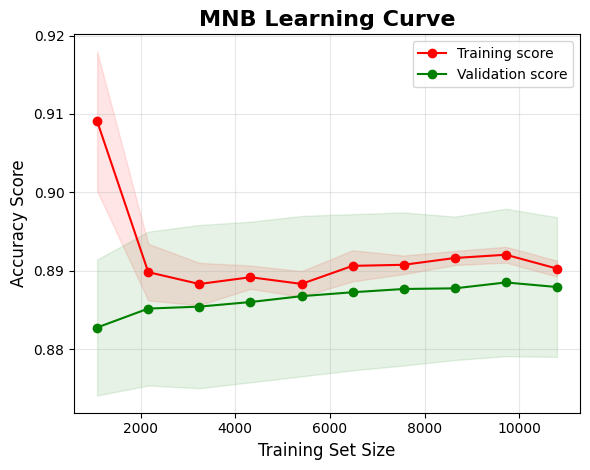

   Learning curve saved to: TF_IDF/models/mnb_learning_curve.png
Creating confusion matrix visualization...


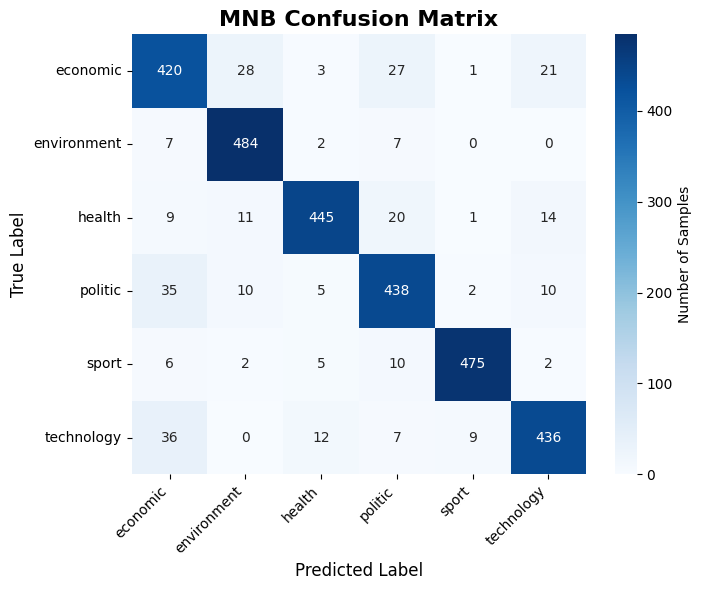

   Confusion matrix saved to: TF_IDF/models/mnb_confusion_matrix.png
Performing error analysis...
   Found 302 misclassified instances out of 3000 test samples
   Overall error rate: 10.07%
   Error analysis saved to: TF_IDF/models/mnb_error_analysis.txt

   Categories with Highest Error Rates:
     economic: 16.00% error rate (420/500 correctly classified)
     technology: 12.80% error rate (436/500 correctly classified)
     politic: 12.40% error rate (438/500 correctly classified)
     health: 11.00% error rate (445/500 correctly classified)
     sport: 5.00% error rate (475/500 correctly classified)
Generating classification report...

MNB model saved to: TF_IDF/models/mnb_model.joblib
Model information saved to: TF_IDF/models/mnb_model_info.txt

MNB Training Summary Report:

Vectorizer Information:
   • File: tfidf_vectorizer_filtered.joblib

Training Results:
   • Training time: 0.01 seconds
   • Training accuracy: 0.8902
   • Cross-validation accuracy: 0.8879 (±0.0089)

Test Per

In [5]:
# MODULE 4: MNB TRAINING
# ============================================================================

# Choose which vectorizer to use:
# "tfidf_vectorizer.joblib" for default TF-IDF (unlimited features)
# "tfidf_vectorizer_filtered.joblib" for feature engineered TF-IDF (3000 features)
VECTORIZER_FILENAME = "tfidf_vectorizer_filtered.joblib"

# Construct full path to vectorizer
vectorizer_path = os.path.join(FEATURES_DIR, VECTORIZER_FILENAME)

# Verify the file exists before proceeding
if not os.path.exists(vectorizer_path):
    print(f"\nERROR: Vectorizer file not found!")
    print(f"Expected path: {vectorizer_path}")
    
    # Show what files actually exist in FEATURES_DIR
    if os.path.exists(FEATURES_DIR):
        print(f"\nFiles currently in {FEATURES_DIR}:")
        for file in os.listdir(FEATURES_DIR):
            if file.endswith('.joblib'):
                print(f"   • {file}")
    else:
        print(f"\nFEATURES_DIR does not exist: {FEATURES_DIR}")
    raise FileNotFoundError(f"Vectorizer file not found: {vectorizer_path}")

# Load the specified vectorizer
try:
    tfidf_vectorizer = joblib.load(vectorizer_path)
    print(f"   • Vectorizer feature count: {len(tfidf_vectorizer.get_feature_names_out()):,}")
except Exception as e:
    print(f"ERROR loading vectorizer: {e}")
    raise

# ============================================================================
# MNB TRAINING FUNCTIONS
# ============================================================================

def train_mnb_model(X_train, y_train, X_test, y_test):

    # Initialize MNB model with default parameters
    mnb_model = MultinomialNB()
    
    # Initialize results dictionary
    results = {
        'model': mnb_model,
        'model_name': 'MNB'
    }
    
    # Track training time
    print("\nStarting MNB training...")
    start_time = time.time()
    
    # Train the model
    mnb_model.fit(X_train, y_train)
    training_time = time.time() - start_time
    results['training_time'] = training_time
    
    # Calculate training accuracy
    train_pred = mnb_model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_pred)
    results['train_accuracy'] = train_accuracy
    
    return results

def perform_cross_validation(model, X_train, y_train, cv_folds=10):

    print(f"\nPerforming {cv_folds}-Fold Cross-Validation...")
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='accuracy')
    
    cv_results = {
        'cv_scores': cv_scores,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    return cv_results

def evaluate_model_on_test(model, X_test, y_test):
    """
    Evaluate the trained model on test data.
    """
    print("\nEvaluating on test set...")
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    test_results = {
        'y_pred': y_pred,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }
    
    return test_results

def create_confusion_matrix_visualization(y_test, y_pred, categories, output_dir):

    print("Creating confusion matrix visualization...")
    
    # Import to avoid any naming conflicts
    import sklearn.metrics
    
    # Create confusion matrix using full module path
    cm = sklearn.metrics.confusion_matrix(y_test, y_pred, labels=categories)
    
    # Create visualization
    plt.figure(figsize=(7.2, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=categories, yticklabels=categories,
                cbar_kws={'label': 'Number of Samples'})
    
    plt.title('MNB Confusion Matrix', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save visualization
    filename = f'mnb_confusion_matrix.png'
    cm_path = os.path.join(output_dir, filename)
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"   Confusion matrix saved to: {cm_path}")
    
    return cm

def create_learning_curve_visualization(model, X_train, y_train, output_dir, cv_folds=10):

    print("Creating learning curve visualization...")
    
    try:
        # Generate learning curve data
        train_sizes = np.linspace(0.1, 1.0, 10)
        train_sizes_abs, train_scores, val_scores = learning_curve(
            model, X_train, y_train, 
            train_sizes=train_sizes, 
            cv=cv_folds, 
            scoring='accuracy',
            n_jobs=-1
        )
        
        # Calculate mean and standard deviation
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)
        
        # Create visualization
        plt.figure(figsize=(6, 4.8))
        plt.plot(train_sizes_abs, train_mean, 'o-', color='r', label='Training score')
        plt.plot(train_sizes_abs, val_mean, 'o-', color='g', label='Validation score')
        plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
        plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')
        
        plt.title('MNB Learning Curve', fontsize=16, fontweight='bold')
        plt.xlabel('Training Set Size', fontsize=12)
        plt.ylabel('Accuracy Score', fontsize=12)
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # Save visualization
        filename = f'mnb_learning_curve.png'
        lc_path = os.path.join(output_dir, filename)
        plt.savefig(lc_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"   Learning curve saved to: {lc_path}")
        
        return {
            'train_sizes': train_sizes_abs,
            'train_scores': train_scores,
            'val_scores': val_scores
        }
    
    except Exception as e:
        print(f"   Warning: Could not generate learning curve. Error: {e}")
        return None

def perform_error_analysis(y_test, y_pred, categories, output_dir):

    print("Performing error analysis...")
    
    # Identify misclassified instances
    misclassified_mask = np.array(y_test) != np.array(y_pred)
    misclassified_indices = np.where(misclassified_mask)[0]
    
    if len(misclassified_indices) == 0:
        print("   No misclassified instances found.")
        return
    
    print(f"   Found {len(misclassified_indices)} misclassified instances out of {len(y_test)} test samples")
    print(f"   Overall error rate: {len(misclassified_indices)/len(y_test)*100:.2f}%")
    
    # Group errors by true category
    errors_by_category = {}
    for idx in misclassified_indices:
        true_category = y_test[idx]
        pred_category = y_pred[idx]
        
        if true_category not in errors_by_category:
            errors_by_category[true_category] = []
        
        errors_by_category[true_category].append(pred_category)
    
    # Calculate error rate by category
    error_rates = {}
    for category in categories:
        category_count = sum(1 for y in y_test if y == category)
        if category_count == 0:
            continue
        
        misclassified_count = len(errors_by_category.get(category, []))
        error_rate = misclassified_count / category_count
        error_rates[category] = error_rate
    
    # Save error analysis to file
    filename = f'mnb_error_analysis.txt'
    error_analysis_path = os.path.join(output_dir, filename)
    
    with open(error_analysis_path, 'w', encoding='utf-8') as f:
        f.write("MNB Error Analysis\n")
        f.write("="*40 + "\n\n")
        f.write(f"Total test samples: {len(y_test)}\n")
        f.write(f"Misclassified samples: {len(misclassified_indices)}\n")
        f.write(f"Overall error rate: {len(misclassified_indices)/len(y_test)*100:.2f}%\n\n")
        
        f.write("Error Rates by Category:\n")
        f.write("-"*30 + "\n")
        sorted_categories = sorted(error_rates.items(), key=lambda x: x[1], reverse=True)
        for category, error_rate in sorted_categories:
            correct_count = sum(1 for y in y_test if y == category) - len(errors_by_category.get(category, []))
            total_count = sum(1 for y in y_test if y == category)
            f.write(f"{category}: {error_rate:.2%} error rate ({correct_count}/{total_count} correctly classified)\n")
        
        # Common confusion pairs
        confusion_pairs = {}
        for true_category, errors in errors_by_category.items():
            for pred_category in errors:
                pair = (true_category, pred_category)
                confusion_pairs[pair] = confusion_pairs.get(pair, 0) + 1
        
        f.write(f"\nMost Common Confusion Pairs (True -> Predicted):\n")
        f.write("-"*50 + "\n")
        sorted_pairs = sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)
        for (true_cat, pred_cat), count in sorted_pairs[:10]:
            f.write(f"{true_cat} -> {pred_cat}: {count} instances\n")
    
    print(f"   Error analysis saved to: {error_analysis_path}")
    
    # Display top categories with highest error rates
    print("\n   Categories with Highest Error Rates:")
    sorted_categories = sorted(error_rates.items(), key=lambda x: x[1], reverse=True)
    for category, error_rate in sorted_categories[:5]:
        correct_count = sum(1 for y in y_test if y == category) - len(errors_by_category.get(category, []))
        total_count = sum(1 for y in y_test if y == category)
        print(f"     {category}: {error_rate:.2%} error rate ({correct_count}/{total_count} correctly classified)")

def save_classification_report(y_test, y_pred, categories, output_dir):

    print("Generating classification report...")
    
    # Generate classification report
    class_report = classification_report(y_test, y_pred, target_names=categories, digits=4)
    
    # Save to file
    filename = f'mnb_classification_report.txt'
    report_path = os.path.join(output_dir, filename)
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("MNB Classification Report\n")
        f.write("="*40 + "\n\n")
        f.write(class_report)
        f.write("\n\n")
        
        # Add per-class metrics
        f.write("Per-Class Metrics Summary:\n")
        f.write("-"*30 + "\n")
        
        for category in categories:
            category_mask = np.array(y_test) == category
            if np.sum(category_mask) > 0:
                category_pred = np.array(y_pred)[category_mask]
                category_true = np.array(y_test)[category_mask]
                
                precision = precision_score(category_true, category_pred, labels=[category], average='macro')
                recall = recall_score(category_true, category_pred, labels=[category], average='macro')
                f1 = f1_score(category_true, category_pred, labels=[category], average='macro')
                
                f.write(f"{category}:\n")
                f.write(f"  Precision: {precision:.4f}\n")
                f.write(f"  Recall: {recall:.4f}\n")
                f.write(f"  F1-Score: {f1:.4f}\n")
                f.write(f"  Support: {np.sum(category_mask)}\n\n")

# ============================================================================
# MNB MODEL TRAINING AND EVALUATION
# ============================================================================

print(f"\nInitializing MNB training pipeline...")

# Get unique categories for analysis
categories = sorted(set(y_train))

# Train MNB model
mnb_results = train_mnb_model(X_train_tfidf, y_train, X_test_tfidf, y_test)

# Perform cross-validation
cv_results = perform_cross_validation(mnb_results['model'], X_train_tfidf, y_train, cv_folds=10)
mnb_results.update(cv_results)

# Evaluate on test set
test_results = evaluate_model_on_test(mnb_results['model'], X_test_tfidf, y_test)
mnb_results.update(test_results)

# Create learning curve visualization
learning_curve_data = create_learning_curve_visualization(
    mnb_results['model'], X_train_tfidf, y_train, MODELS_DIR, cv_folds=10
)

# Create confusion matrix visualization
cm_result = create_confusion_matrix_visualization(
    y_test, mnb_results['y_pred'], categories, MODELS_DIR
)

# Perform error analysis
perform_error_analysis(y_test, mnb_results['y_pred'], categories, MODELS_DIR)

# Generate classification report
save_classification_report(y_test, mnb_results['y_pred'], categories, MODELS_DIR)

# Save the trained model
model_filename = f'mnb_model.joblib'
model_path = os.path.join(MODELS_DIR, model_filename)
joblib.dump(mnb_results['model'], model_path)

print(f"\nMNB model saved to: {model_path}")

# Create a model info file for clarity  
info_filename = f'mnb_model_info.txt'
info_path = os.path.join(MODELS_DIR, info_filename)

with open(info_path, 'w', encoding='utf-8') as f:
    f.write(f"MNB Model Information\n")
    f.write("="*60 + "\n\n")
    f.write("Model Files:\n")
    f.write(f"   • Model: {model_filename}\n")
    f.write(f"   • Corresponding Vectorizer: {VECTORIZER_FILENAME}\n\n")
    f.write("Dataset Information:\n")
    f.write(f"   • Feature count: {X_train_tfidf.shape[1]:,}\n")
    f.write(f"   • Training samples: {X_train_tfidf.shape[0]:,}\n")
    f.write(f"   • Test samples: {X_test_tfidf.shape[0]:,}\n\n")
    f.write("Vectorizer Information:\n")
    f.write(f"   • File: {VECTORIZER_FILENAME}\n")
    f.write(f"   • Path: {vectorizer_path}\n")
    f.write(f"\nModel Training:\n")
    f.write(f"   • Algorithm: Multinomial Naive Bayes\n")
    f.write(f"   • Parameters: Default\n")
    f.write(f"   • Training time: {mnb_results['training_time']:.2f} seconds\n")
    f.write(f"   • Test accuracy: {mnb_results['accuracy']:.4f}\n")

print(f"Model information saved to: {info_path}")

# ============================================================================
# SUMMARY REPORT
# ============================================================================

print("\nMNB Training Summary Report:")
print("="*60)

print(f"\nVectorizer Information:")
print(f"   • File: {VECTORIZER_FILENAME}")

print(f"\nTraining Results:")
print(f"   • Training time: {mnb_results['training_time']:.2f} seconds")
print(f"   • Training accuracy: {mnb_results['train_accuracy']:.4f}")
print(f"   • Cross-validation accuracy: {mnb_results['cv_mean']:.4f} (±{mnb_results['cv_std']:.4f})")

print(f"\nTest Performance:")
print(f"   • Test accuracy: {mnb_results['accuracy']:.4f}")
print(f"   • Test precision: {mnb_results['precision']:.4f}")
print(f"   • Test recall: {mnb_results['recall']:.4f}")
print(f"   • Test F1-score: {mnb_results['f1']:.4f}")


print("="*60)